# Predicción de efectivización de presupuesto

Aquí descripción del problema, datos que ingresan, procesaminto que se le hace, salida esperada.

<br/><br/><br/><br/>
## 1. Contexto

1.1. Instalación y activación del entorno virtual

In [1]:
import os
if not os.path.exists('venv'):
    !python3 -m venv venv

!source venv/bin/activate

1.2. Instalación de paquetes

In [ ]:
!pip3 install scipy
!pip3 install numpy
!pip3 install pandas
!pip3 install seaborn
!pip3 install openpyxl
!pip3 install matplotlib
!pip3 install scikit-learn


1.3. Importación de librerías

In [3]:
# Importación de librerías

import pandas as pd # Para manejo de dataframes
import json # Para manipulación de diccionarios
import numpy as np # Para manipulación numérica y vectorial
from scipy.stats import zscore # Para realizar cálculos estadísticos
import matplotlib.pyplot as plt # Para plotear las gráficas
import seaborn as sns # Para la visualización de gráficas conjuntas
from sklearn.model_selection import train_test_split # Para manipulación de subdatasets
from sklearn.linear_model import LogisticRegression # Para crear el modelo de regresión logística
from sklearn.decomposition import PCA # Para simplificar el dataset
from openpyxl import * # Para exportar a XML
from sklearn import metrics # Para calcular las métricas de los modelos

1.4. Definición de constantes

In [4]:
EPSILON = 0.000001 # Valor mínimo aceptable
TRAIN = 0.7

1.5. Carga de datos

In [5]:
df = pd.read_csv('data/datos_originales.csv', sep=";")

1.6. Estructura del dataset de entrada

In [6]:
total_rows, total_cols = df.shape
print(f"Total de filas/registros: {total_rows}")
print(f"Total de columnas/variables: {total_cols}")

Total de filas/registros: 10000
Total de columnas/variables: 10


1.7. Explicación de las variables

In [7]:
list(df.columns.values)

['id_cliente',
 'edad_cliente',
 'inclinacion_tejado',
 'antiguedad_propiedad',
 'consumo_anual_mmpp',
 'horas_trabajo',
 'modalidad_trabajo',
 'orientacion',
 'ratio_ingresos_deudas',
 'contrata']

<table>
    <th>
        <td>Tipología</td>
        <td>Descripción</td>
    </th>
    <tr>
        <td>id_cliente</td>
        <td>int</td>
        <td>Identificador numérico para identificar un nuevo registro de presupuesto solicitado</td>
    </tr>
    <tr>
        <td>edad_cliente</td>
        <td>int</td>
        <td>Edad del cliente responsable de solicitar el presupuesto</td>
    </tr>
    <tr>
        <td>inclinacion_tejado</td>
        <td>categórica</td>
        <td>Inclinación del tejado donde se realizará la instalación, implica costos de instalación distintos</td>
    </tr>
    <tr>
        <td>antiguedad_propiedad</td>
        <td>int</td>
        <td>Antigüedad de la propiedad en años</td>
    </tr>
    <tr>
        <td>consumo_anual_mmpp</td>
        <td>int</td>
        <td>Consumo anual de luz ezpresado en miles de pesos urugayos</td>
    </tr>
    <tr>
        <td>horas_trabajo</td>
        <td>int</td>
        <td>Horas de trabajo semanal promedio</td>
    </tr>
    <tr>
        <td>modalidad_trabajo</td>
        <td>categórica</td>
        <td>Modalidad de trabajo remoto (R) o presencial (P)</td>
    </tr>
    <tr>
        <td>orientacion</td>
        <td>categórica</td>
        <td>Orientación del tejado de la vivienda, Sur (S), Norte (N), Este (E), Oeste (O)</td>
    </tr>
    <tr>
        <td>ratio_ingresos_deudas</td>
        <td>float</td>
        <td>Proporción entre ingresos obtenidos y gastos que enfrenta</td>
    </tr>
    <tr>
        <td>contrata</td>
        <td>int</td>
        <td>Estado de contratación del servicio, Ha contratado (1), No ha contratado (0)</td>
    </tr>
</table>    

1.8. Distribución y relación entre las distintas variables que componen el Dataset

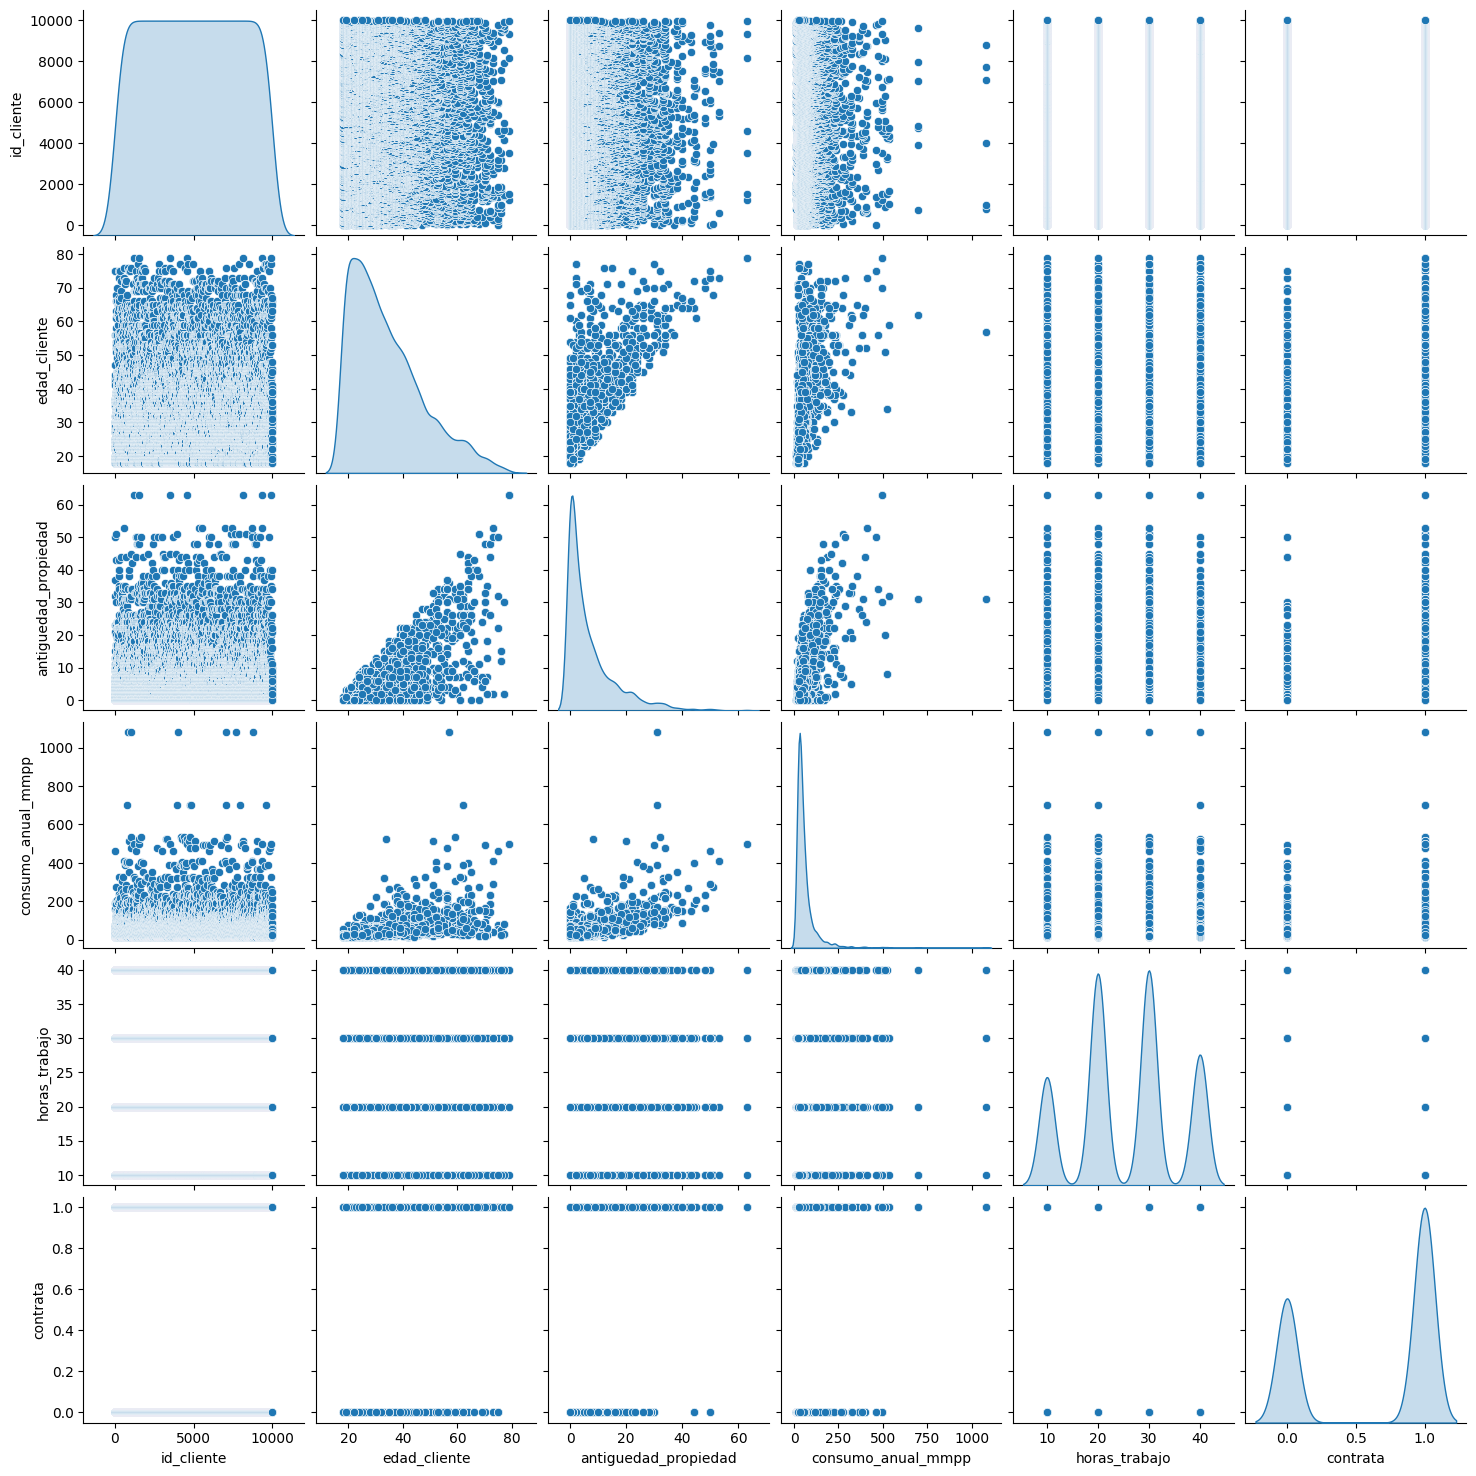

In [8]:
sns.pairplot(data=df, diag_kind='kde')

<br/><br/><br/><br/>
## 2. Etapa de procesado

2.1. Se eliminan las columnas de valor constante que pudiera haber

In [9]:
df = df[[i for i in df if len(set(df[i]))>1]]

2.2. Se eliminan las columnas que tuvieran la mitad+1 de valores a None 

In [10]:
min_nulls = (total_rows / 2) +1
df = df.dropna(axis=1, thresh=min_nulls)

2.3. Se eliminan aquellas filas restantes que tengan valores a None

In [11]:
df = df.dropna()

2.4. Se eliminan los registros duplicados 

In [12]:
df = df.drop_duplicates()

2.5. Se elimina la columna ID de cliente que no aporta desde el punto de vista predictivo

In [13]:
df = df.drop(columns=['id_cliente'])

2.6. Se eliminan los registros outliers, basándose en el z-score de la columna, en relación con la media de la columna y la desviación estándar

In [14]:
constrains = df.select_dtypes(include=[np.number]).apply(lambda x: np.abs(np.abs(zscore(x)) - 3) > EPSILON).all(axis=1)
df.drop(df.index[~constrains], inplace=True)

2.7. Se estandarizan todos los strings a lowercase y se convierten a valores numéricos

In [15]:
df = df.apply(lambda x: x.map(lambda s: s.lower() if isinstance(s, str) else s) if x.dtype == 'O' else x)

2.8. Se modifica el separador de decimales y se fuerza la columna a que sea de tipo float. 

In [16]:
print(f"Formato de columna original: {df['ratio_ingresos_deudas'].dtype}")
df['ratio_ingresos_deudas'] = pd.to_numeric(df['ratio_ingresos_deudas'].str.replace(',', '.'), errors='coerce').astype(float)
print(f"Formato de columna procesada: {df['ratio_ingresos_deudas'].dtype}")

Formato de columna original: object
Formato de columna procesada: float64


2.9. Se guarda un mapeo de los datos en formato categórico para posterior conversión de categórico a numérico

In [17]:
inclinacion_tejado_map = {}
orientacion_map = {}
modalidad_trabajo_map = {}

count=0
for i in df.inclinacion_tejado.unique():
    inclinacion_tejado_map[i] = count
    count+=1

count=0
for i in df.orientacion.unique():
    orientacion_map[i] = count
    count+=1

count=0
for i in df.modalidad_trabajo.unique():
    modalidad_trabajo_map[i] = count
    count+=1


print(f"Inclinaciones: \n{json.dumps(inclinacion_tejado_map, indent=4)}\n")
print(f"Orientaciones: \n{json.dumps(orientacion_map, indent=4)}\n")
print(f"Modalidad de trabajo: \n{json.dumps(modalidad_trabajo_map, indent=4)}")

Inclinaciones: 
{
    "muyinclinado": 0,
    "pocoinclinado": 1,
    "plano": 2,
    "suelo": 3
}

Orientaciones: 
{
    "e": 0,
    "s": 1,
    "o": 2,
    "n": 3
}

Modalidad de trabajo: 
{
    "r": 0,
    "p": 1
}


In [18]:
# Cambia los valores por su correspondiente indice
for i in inclinacion_tejado_map.keys():
    df.loc[df['inclinacion_tejado'] == i, 'inclinacion_tejado'] = inclinacion_tejado_map[i]

for i in orientacion_map.keys():
    df.loc[df['orientacion'] == i, 'orientacion'] = orientacion_map[i]

for i in modalidad_trabajo_map.keys():
    df.loc[df['modalidad_trabajo'] == i, 'modalidad_trabajo'] = modalidad_trabajo_map[i]

2.10. Se convierten todos los valores a tipo float, incluso aquellos categóricos numéricos aunque no es necesario 

In [19]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce').astype(float)
df.dtypes

edad_cliente             float64
inclinacion_tejado       float64
antiguedad_propiedad     float64
consumo_anual_mmpp       float64
horas_trabajo            float64
modalidad_trabajo        float64
orientacion              float64
ratio_ingresos_deudas    float64
contrata                 float64
dtype: object

2.11. Se mezclan todos los registros para evitar el orden

In [20]:
df.reset_index(inplace=True, drop=True)
df.head()

,edad_cliente,inclinacion_tejado,antiguedad_propiedad,consumo_anual_mmpp,horas_trabajo,modalidad_trabajo,orientacion,ratio_ingresos_deudas,contrata
0,28.0,0.0,2.0,24.0,30.0,0.0,0.0,0.19,0.0
1,20.0,1.0,0.0,19.0,20.0,0.0,0.0,0.28,1.0
2,30.0,2.0,13.0,42.0,30.0,1.0,0.0,0.52,1.0
3,41.0,0.0,9.0,68.0,30.0,1.0,1.0,0.70,0.0
4,18.0,0.0,0.0,17.0,20.0,1.0,0.0,0.82,0.0


<br/><br/><br/><br/>
## 3. Etapa de descripción

In [21]:
# Estructura del dataset
print("#### ROWS x COLS ####\n",df.shape,"\n")

# Mostrar el balanceo de registros en función de su clase
print("#### BALANCEO SEGÚN SU CLASE ####\n", pd.Series(df['contrata']).value_counts(), "\n")

# Imprimir información estadística del dataframe
print("#### ESTADÍSTICAS GENERALES DEL DATASET ####\n",df.describe(),"\n")

#### ROWS x COLS ####
 (10000, 9) 

#### BALANCEO SEGÚN SU CLASE ####
 contrata
1.0    6336
0.0    3664
Name: count, dtype: int64 

#### ESTADÍSTICAS GENERALES DEL DATASET ####
        edad_cliente  inclinacion_tejado  antiguedad_propiedad  \
count  10000.000000        10000.000000          10000.000000   
mean      34.179300            0.924000              6.961500   
std       13.138083            0.856912              8.993737   
min       18.000000            0.000000              0.000000   
25%       24.000000            0.000000              0.000000   
50%       31.000000            1.000000              4.000000   
75%       42.000000            1.000000             10.000000   
max       79.000000            3.000000             63.000000   

       consumo_anual_mmpp  horas_trabajo  modalidad_trabajo   orientacion  \
count        10000.000000   10000.000000       10000.000000  10000.000000   
mean            59.690200      25.532000           0.417600      0.909300   
std  

<br/><br/><br/><br/>
## 4. Etapa de separación de datasets

4.1. Se aplica normalización _min-max_ para todos los elementos numéricos de tipo no-categórico

In [22]:
df['edad_cliente'] = (df['edad_cliente'] - df['edad_cliente'].min()) / ( df['edad_cliente'].max() - df['edad_cliente'].min())
df['antiguedad_propiedad'] = (df['antiguedad_propiedad'] - df['antiguedad_propiedad'].min()) / ( df['antiguedad_propiedad'].max() - df['antiguedad_propiedad'].min())
df['consumo_anual_mmpp'] = (df['consumo_anual_mmpp'] - df['consumo_anual_mmpp'].min()) / ( df['consumo_anual_mmpp'].max() - df['consumo_anual_mmpp'].min())

4.2. Se separan las variables de predicción de la variable de clase 

In [23]:
X = df.iloc[:,:-1].values # n-1 cols
Y = df.iloc[:,-1:].values # 1 col

In [24]:
print(f"Tamaño matriz de variables de decisión: {X.shape[0]}x{X.shape[1]}")
print(f"Tamaño de vector de variable de clase: {Y.shape[0]}x{Y.shape[1]}")

Tamaño matriz de variables de decisión: 10000x8
Tamaño de vector de variable de clase: 10000x1


4.3. Se dividen los dataset en train y test

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size = 1-TRAIN, random_state = 42 ) #, random_state = 42 # fija la randomización en las particiones
print(f"Dimensiones de X_train: {X_train.shape[0]}x{X_train.shape[1]}")
print(f"Dimensiones de Y_train: {Y_train.shape[0]}x{Y_train.shape[1]}\n")
print(f"Dimensiones de X_test: {X_test.shape[0]}x{X_test.shape[1]}")
print(f"Dimensiones de Y_test: {Y_test.shape[0]}x{Y_test.shape[1]}")

Dimensiones de X_train: 6999x8
Dimensiones de Y_train: 6999x1

Dimensiones de X_test: 3001x8
Dimensiones de Y_test: 3001x1


4.4. Se aplica PCA para detectar componentes principales y cambiar su dimensionalidad

In [26]:
pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
print("-> SE APLICA PCA \n", pca.explained_variance_ratio_)


-> SE APLICA PCA 
 [9.77455752e-01 1.16507665e-02 7.25169274e-03 2.54315362e-03
 6.85655686e-04 3.16301042e-04 7.56527877e-05 2.10256523e-05]


4.5. Se muestra la información sobre los nuevos datasets 

In [27]:
# Imprimir información sobre los nuevos datasets
print("#### VARIABLES DE PREDICCIÓN ####\n",X.shape[1],"\n")
print("#### VARIABLES DE CLASE ####\n",Y.shape[1],"\n")

#### VARIABLES DE PREDICCIÓN ####
 8 

#### VARIABLES DE CLASE ####
 1 



<br/><br/><br/><br/>
## 5. Etapa de entrenamiento

5.1. Se realiza el entrenamiento del modelo de Regresión Logística

In [28]:
model = LogisticRegression(tol=EPSILON, max_iter=500, multi_class = 'auto', solver = 'liblinear', class_weight = 'balanced')
model.fit( X_train, Y_train.ravel() )

LogisticRegression(class_weight='balanced', max_iter=500, solver='liblinear',
                   tol=1e-06)

<br/><br/><br/><br/>
## 6. Etapa de predicción

6.1. Se realiza la predicción utilizando el modelo entrenado.

In [29]:
Y_pred = model.predict( X_test )
Y_pred

array([1., 1., 0., ..., 0., 1., 0.])

<br/><br/><br/><br/>
## 7. Etapa de evaluación

7.1. Se definen las listas para construir la matriz de confusión

In [30]:
real_list = []
pred_list = []

7.2. Se evalúa la bondad del modelo de regresión 

In [31]:
count = 0
correctly_classified = 0
for count in range( np.size( Y_pred ) ) :
    
    # Cargar las listas de comparación
    real_list.append(Y_test[count])
    pred_list.append(Y_pred[count])

    # Verificar el acierto
    if Y_test[count] == Y_pred[count] :             
        correctly_classified = correctly_classified + 1
    count = count + 1

7.3. Se muestran las estadísticas obtenidas

In [32]:
# Resultados
print("#### MÉTRICAS ####")
print( "ACCURACY: ",(correctly_classified / count ) * 100, "%" )

# Obtiene todas las métricas de clasificación
print(metrics.classification_report(y_true=Y_test, y_pred=Y_pred))

#### MÉTRICAS ####
ACCURACY:  72.27590803065644 %
              precision    recall  f1-score   support

         0.0       0.60      0.69      0.64      1081
         1.0       0.81      0.74      0.77      1920

    accuracy                           0.72      3001
   macro avg       0.71      0.72      0.71      3001
weighted avg       0.73      0.72      0.73      3001



Crear y mostrar la matriz de confusión de los resultados de test

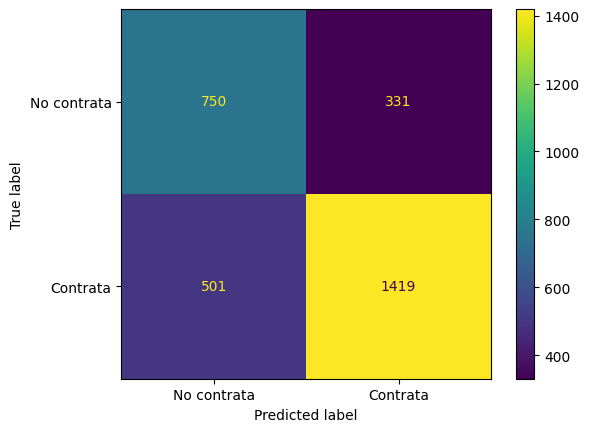

In [33]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['No contrata', 'Contrata'])
import matplotlib.pyplot as plt
cm_display.plot()
plt.show()

Análisis utilizando Curva ROC-AUC

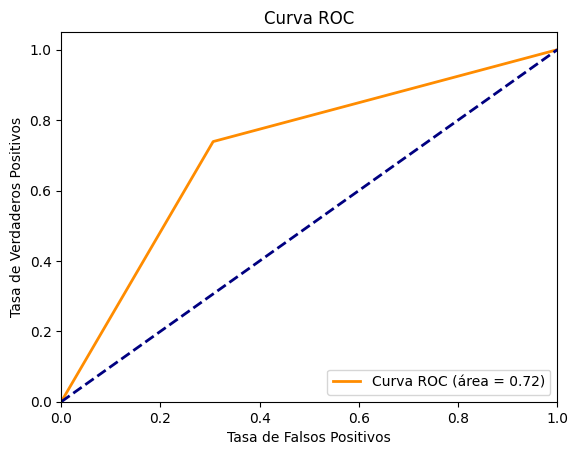

In [34]:
from sklearn.metrics import roc_curve, auc
# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()